In [ ]:
#Import library
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

#Buat direktori
base_dir = '/content/drive/MyDrive/skripsi'
!ls '/content/drive/MyDrive/skripsi'


data  train  validasi


In [ ]:
import os

#menentukan direktorinya
data_dir = os.path.join(base_dir, 'data')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validasi')

In [ ]:
mild_dir = os.path.join(data_dir, 'mild/')
moderate_dir = os.path.join(data_dir, 'moderate/')
no_DR_dir = os.path.join(data_dir, 'no_DR/')
proliferative_dir = os.path.join(data_dir, 'proliferative')
severe_dir = os.path.join(data_dir, 'severe')

print("Jumlah Data Latih di Tiap Kelas")
print("Jumlah Gambar  mild            = ", len(os.listdir(mild_dir)))
print("Jumlah Gambar  moderate        = ", len(os.listdir(moderate_dir)))
print("Jumlah Gambar  no_DR           = ", len(os.listdir(no_DR_dir)))
print("Jumlah Gambar  proliferative   = ", len(os.listdir(proliferative_dir)))
print("Jumlah Gambar  severe          = ", len(os.listdir(severe_dir)))

Jumlah Data Latih di Tiap Kelas
Jumlah Gambar  mild            =  600
Jumlah Gambar  moderate        =  600
Jumlah Gambar  no_DR           =  600
Jumlah Gambar  proliferative   =  600
Jumlah Gambar  severe          =  600


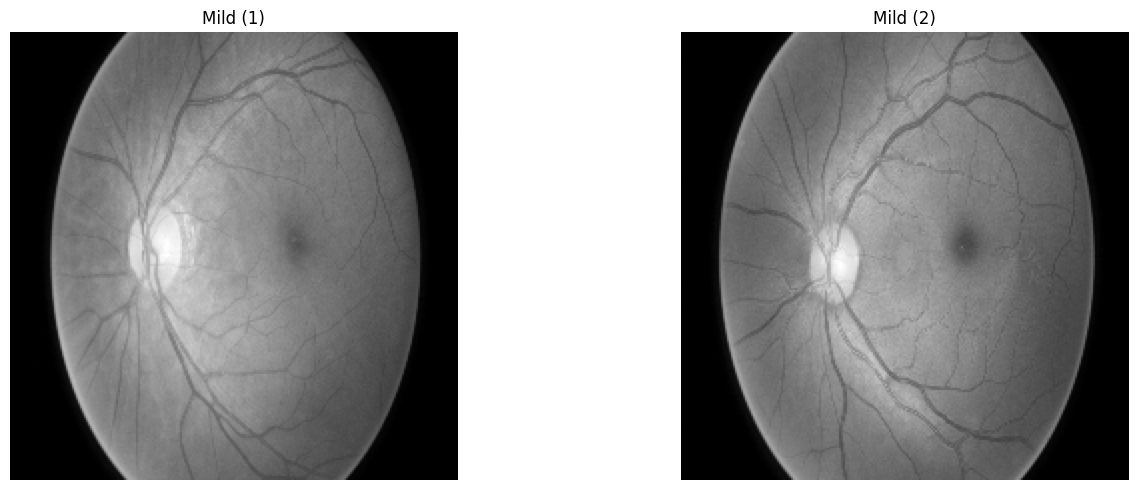

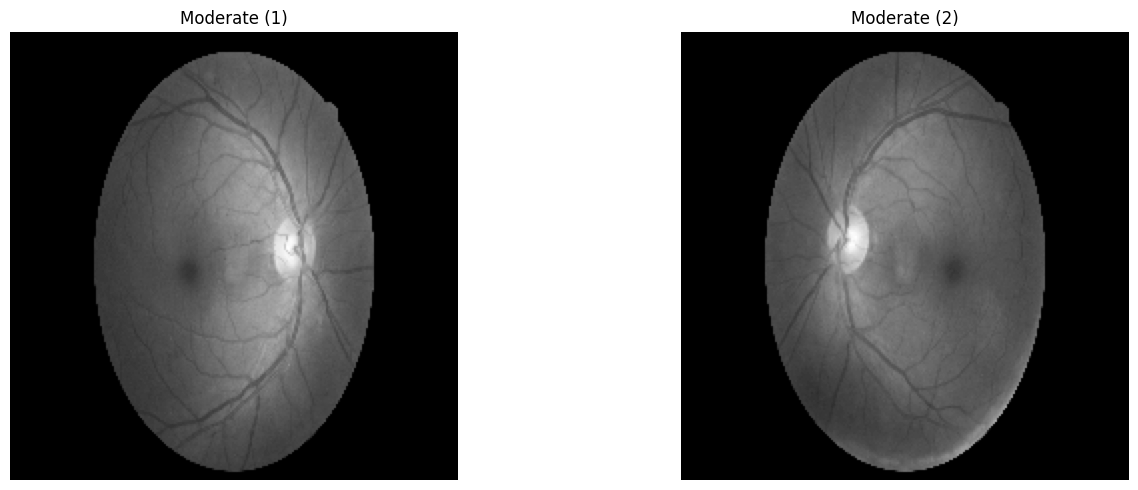

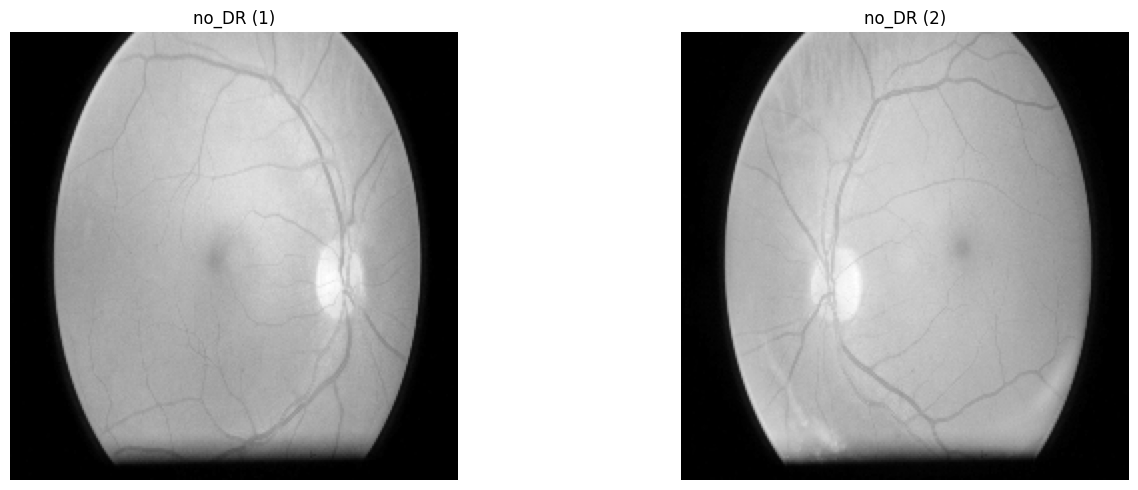

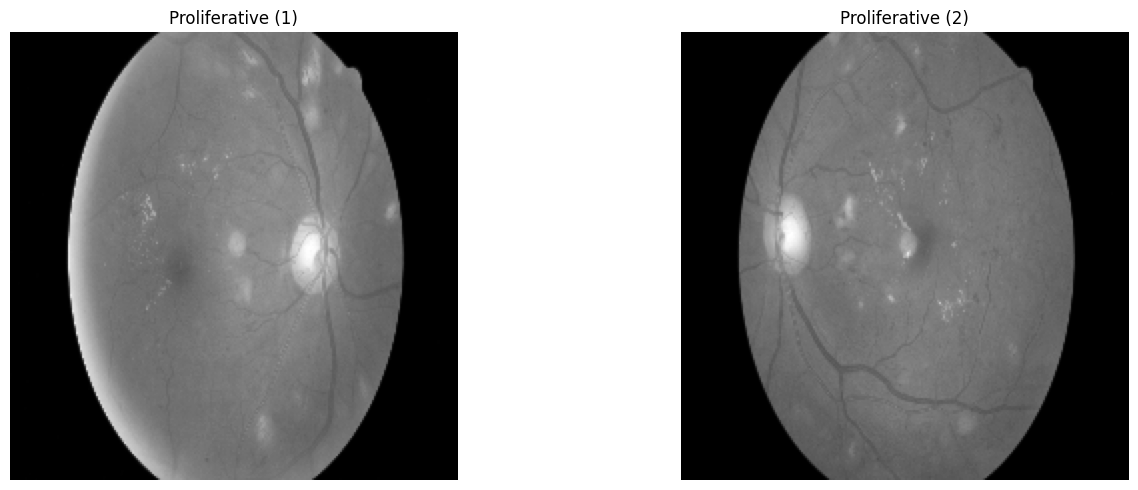

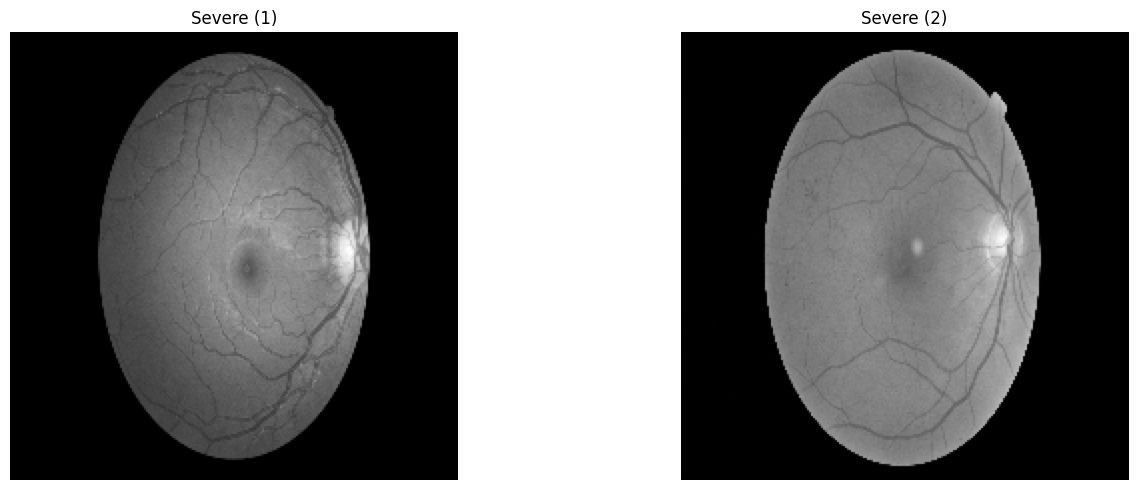

In [ ]:
# Ukuran gambar yang diinginkan
IMAGE_SIZE = (224, 224)

# Import the OpenCV library
import cv2

# Fungsi untuk menampilkan gambar grayscale dari suatu direktori
def show_grayscale_images(directory, class_name):
    image_paths = [os.path.join(directory, file) for file in os.listdir(directory)[:2]]  # Mengambil 5 gambar pertama dari direktori

    fig, axs = plt.subplots(1, len(image_paths), figsize=(15, 5))

    for i, image_path in enumerate(image_paths):
        image = cv2.imread(image_path)
        resized_image = cv2.resize(image, IMAGE_SIZE)  # Mengubah ukuran gambar
        gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
        axs[i].imshow(gray_image, cmap='gray')
        axs[i].set_title(f"{class_name} ({i+1})")
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Menampilkan gambar grayscale dari setiap kelas
show_grayscale_images(mild_dir, "Mild")
show_grayscale_images(moderate_dir, "Moderate")
show_grayscale_images(no_DR_dir, "no_DR")
show_grayscale_images(proliferative_dir, "Proliferative")
show_grayscale_images(severe_dir, "Severe")

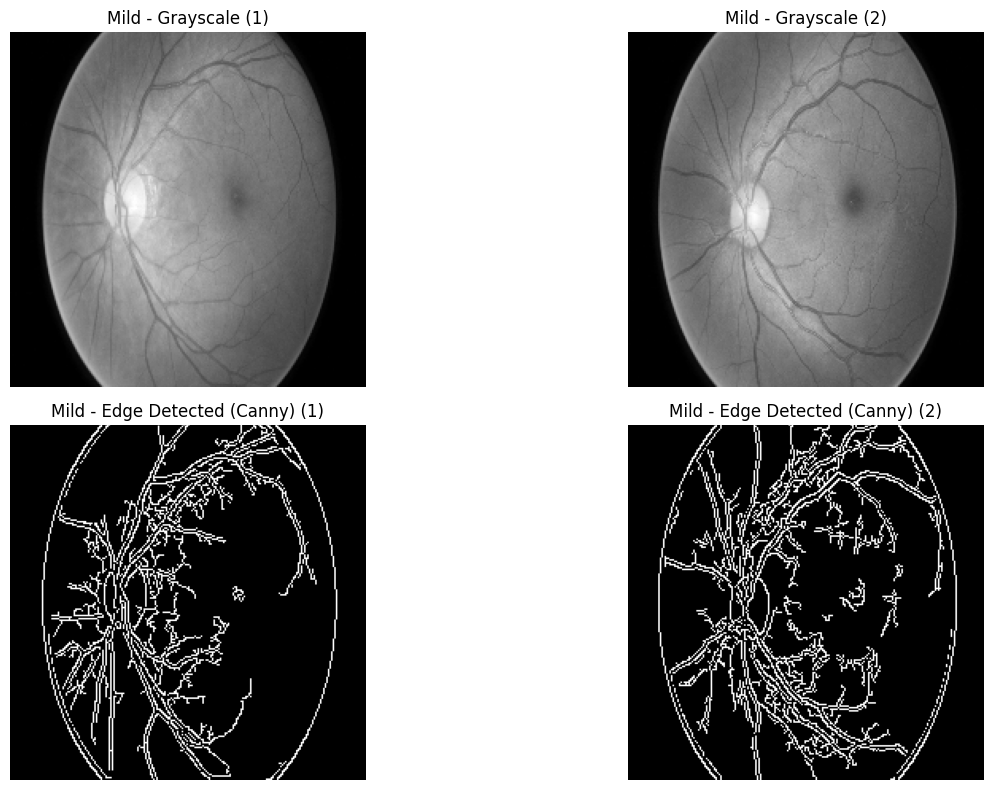

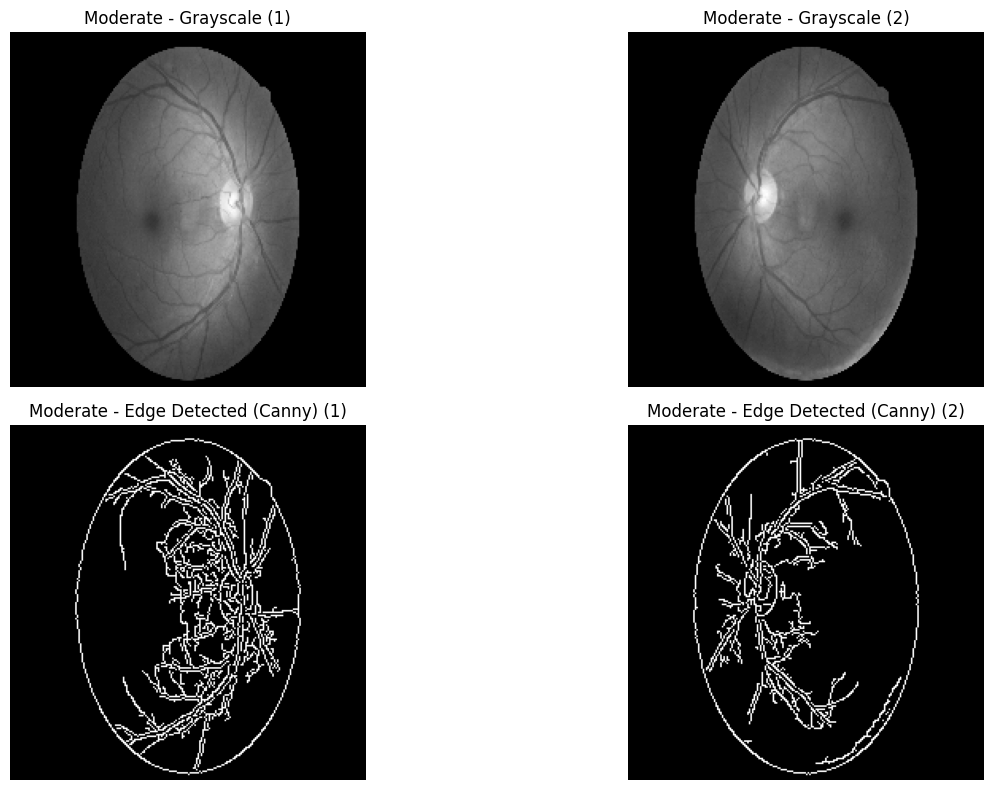

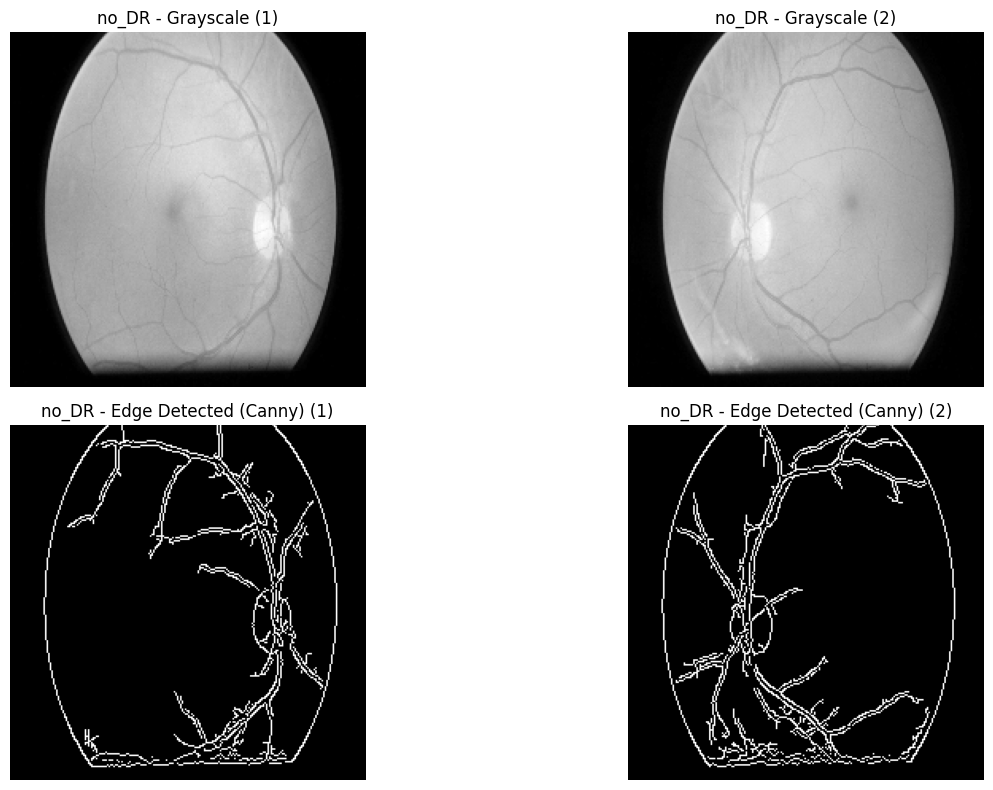

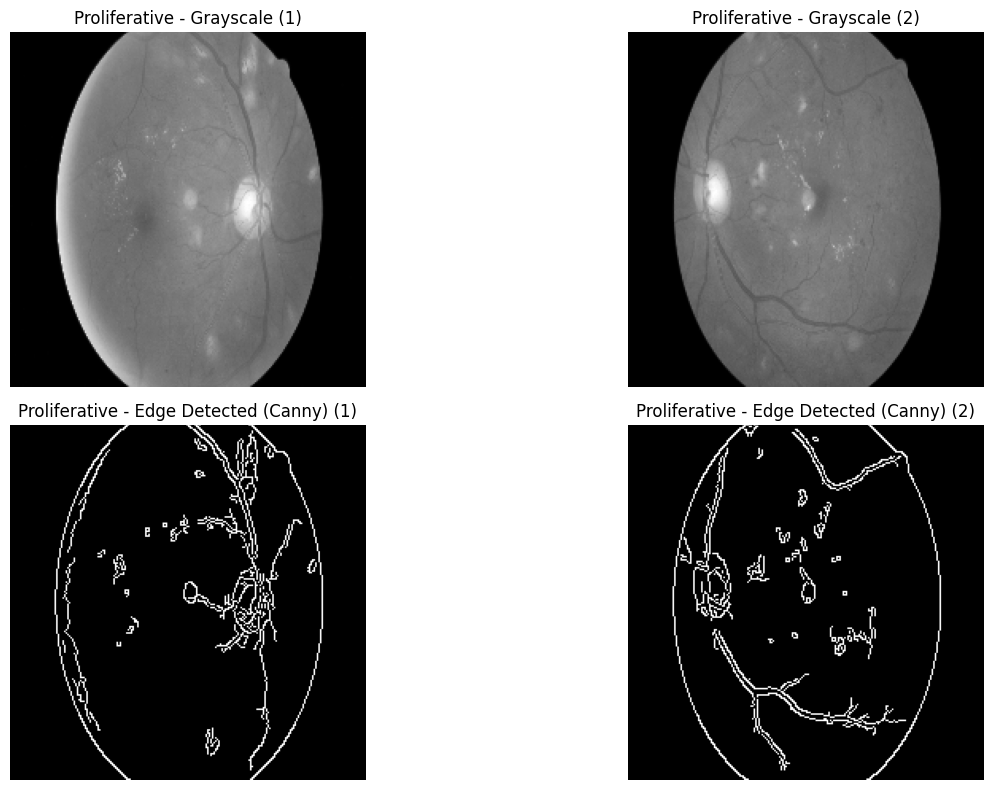

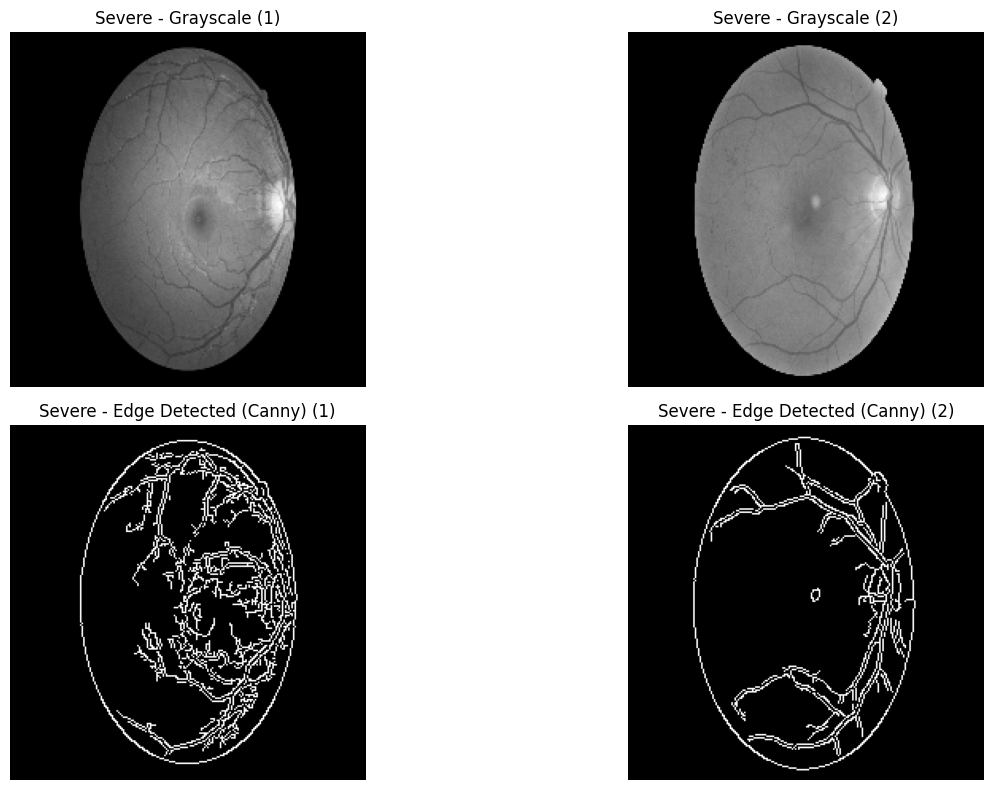

In [ ]:
# Ukuran gambar yang diinginkan
IMAGE_SIZE = (224, 224)

# Fungsi untuk deteksi tepi menggunakan operator Canny
def edge_detection_canny(image):
    """
    Melakukan deteksi tepi menggunakan operator Canny pada gambar grayscale.

    Args:
        image: Gambar grayscale dalam bentuk NumPy array.

    Returns:
        edge_detected_image: Gambar hasil deteksi tepi dalam bentuk NumPy array.
    """
    # Menentukan batas bawah dan atas untuk deteksi tepi adaptif
    lower_threshold = 30
    upper_threshold = 100

    # Menggunakan fungsi Canny dari OpenCV untuk deteksi tepi
    edge_detected_image = cv2.Canny(image, lower_threshold, upper_threshold)

    return edge_detected_image

# Fungsi untuk menampilkan gambar grayscale beserta hasil deteksi tepi menggunakan Canny
def show_grayscale_images_with_edges(directory, class_name):
    """
    Menampilkan gambar grayscale dari lima gambar pertama dalam direktori,
    serta hasil deteksi tepi menggunakan operator Canny.

    Args:
        directory (str): Path ke direktori yang berisi gambar.
        class_name (str): Nama kelas untuk ditampilkan di judul gambar.

    Returns:
        None
    """
    # Mengambil 4 gambar pertama dari direktori
    image_paths = [os.path.join(directory, file) for file in os.listdir(directory)[:2]]

    # Membuat subplot untuk menampilkan gambar
    fig, axs = plt.subplots(2, len(image_paths), figsize=(15, 8))

    for i, image_path in enumerate(image_paths):
        # Memuat dan mengubah ukuran gambar
        image = cv2.imread(image_path)
        resized_image = cv2.resize(image, IMAGE_SIZE)  # Mengubah ukuran gambar
        gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

        # Deteksi tepi menggunakan operator Canny
        edge_detected_image = edge_detection_canny(gray_image)

        # Menampilkan gambar grayscale
        axs[0, i].imshow(gray_image, cmap='gray')
        axs[0, i].set_title(f"{class_name} - Grayscale ({i+1})")
        axs[0, i].axis('off')

        # Menampilkan hasil deteksi tepi
        axs[1, i].imshow(edge_detected_image, cmap='gray')
        axs[1, i].set_title(f"{class_name} - Edge Detected (Canny) ({i+1})")
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Menampilkan gambar grayscale dan hasil deteksi tepi menggunakan Canny dari setiap kelas
show_grayscale_images_with_edges(mild_dir, "Mild")
show_grayscale_images_with_edges(moderate_dir, "Moderate")
show_grayscale_images_with_edges(no_DR_dir, "no_DR")
show_grayscale_images_with_edges(proliferative_dir, "Proliferative")
show_grayscale_images_with_edges(severe_dir, "Severe")


In [ ]:
#Direktori isi latih
train_mild = os.path.join(train_dir, 'mild/')
train_moderate = os.path.join(train_dir, 'moderate/')
train_no_DR = os.path.join(train_dir, 'no_DR/')
train_proliferative = os.path.join(train_dir, 'proliferative/')
train_severe = os.path.join(train_dir, 'severe/')

#Direktori isi uji
validation_mild = os.path.join(validation_dir, 'mild/')
validation_moderate = os.path.join(validation_dir, 'moderate/')
validation_no_DR = os.path.join(validation_dir, 'no_DR/')
validation_proliferative = os.path.join(validation_dir, 'proliferative/')
validation_severe = os.path.join(validation_dir, 'severe/')


In [ ]:
# import os
# import random
# from shutil import copyfile

# def train_val_split(source, train, val, train_ratio, val_ratio):
#     # Load list of files in source directory
#     file_list = os.listdir(source)
#     total_size = len(file_list)

#     # Calculate sizes for train and validation split
#     train_size = int(train_ratio * total_size)
#     val_size = int(val_ratio * total_size)

#     # Sample files for train and validation split
#     randomized = random.sample(file_list, total_size)
#     train_files = randomized[0:train_size]
#     val_files = randomized[train_size:train_size + val_size]

#     # Create directories if they don't exist
#     os.makedirs(train, exist_ok=True)
#     os.makedirs(val, exist_ok=True)

#     # Copy files to train and val directories
#     for file_name in train_files:
#         source_file = os.path.join(source, file_name)
#         destination = os.path.join(train, file_name)
#         copyfile(source_file, destination)

#     for file_name in val_files:
#         source_file = os.path.join(source, file_name)
#         destination = os.path.join(val, file_name)
#         copyfile(source_file, destination)

# # Rasio data
# train_ratio = 0.8
# val_ratio = 0.2

# # Pembagian data untuk setiap kelas
# source_00 = mild_dir
# train_00 = train_mild
# val_00 = validation_mild
# train_val_split(source_00, train_00, val_00, train_ratio, val_ratio)

# source_01 = moderate_dir
# train_01 = train_moderate
# val_01 = validation_moderate
# train_val_split(source_01, train_01, val_01, train_ratio, val_ratio)

# source_02 = no_DR_dir
# train_02 = train_no_DR
# val_02 = validation_no_DR
# train_val_split(source_02, train_02, val_02, train_ratio, val_ratio)

# source_03 = proliferative_dir
# train_03 = train_proliferative
# val_03 = validation_proliferative
# train_val_split(source_03, train_03, val_03, train_ratio, val_ratio)

# source_04 = severe_dir
# train_04 = train_severe
# val_04 = validation_severe
# train_val_split(source_04, train_04, val_04, train_ratio, val_ratio)


In [ ]:
print('Jumlah Train  mild                = ', len(os.listdir(train_mild)))
print('Jumlah Train  moderate            = ', len(os.listdir(train_moderate)))
print('Jumlah Train  no_DR               = ', len(os.listdir(train_no_DR)))
print('Jumlah Train proliferative        = ', len(os.listdir(train_proliferative)))
print('Jumlah Train severe               = ', len(os.listdir(train_severe)))
print('=======================================================================================')
print('Jumlah validasi  mild             = ', len(os.listdir(validation_mild)))
print('Jumlah validasi  moderate         = ', len(os.listdir(validation_moderate)))
print('Jumlah validasi  no_DR            = ', len(os.listdir(validation_no_DR)))
print('Jumlah validasi proliferative     = ', len(os.listdir(validation_proliferative)))
print('Jumlah validasi severe            = ', len(os.listdir(validation_severe)))

Jumlah Train  mild                =  480
Jumlah Train  moderate            =  480
Jumlah Train  no_DR               =  480
Jumlah Train proliferative        =  480
Jumlah Train severe               =  480
Jumlah validasi  mild             =  120
Jumlah validasi  moderate         =  120
Jumlah validasi  no_DR            =  120
Jumlah validasi proliferative     =  120
Jumlah validasi severe            =  120


In [ ]:
!pip install tensorflow

import tensorflow as tf # Import TensorFlow
from tensorflow.keras.applications import VGG19 # Import VGG19 class

# Download pre-trained model VGG19
vgg = VGG19(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='max',
    classes=1000,
    classifier_activation="softmax",
)
vgg.summary()

574710816/574710816 [==============================] - 20s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [ ]:
vgg.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_4')>

In [ ]:
#Buat parameter sebelumnya tidak dilatih lagi
for layer in vgg.layers:
  layer.trainable = False
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from keras.models import Model
from keras.layers import Dense
from keras.layers import Dropout

# Mengambil output dari layer sebelum layer prediksi 1000
x = vgg.layers[-2].output

x = Dropout(0.8)(x) # Tambahkan layer dropout dengan rate=0.8
# Membuat layer prediksi baru dengan 5 unit dan nama 'prediksi'
predictions = Dense(5, activation='softmax', name='prediksi')(x)

# Membuat model baru
model = Model(inputs=vgg.input, outputs=predictions)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from keras import optimizers


adam = optimizers.Adam()
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [ ]:
from keras import optimizers
import tensorflow as tf

# Definisikan metrik F1
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

# Inisialisasi optimizer menggunakan SGD
sgd = optimizers.SGD()

# Kompilasi model menggunakan SGD sebagai optimizer
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall'),
                  F1Score(name='f1_score')
              ])

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=(0.5, 1.5)
)


In [ ]:
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=(0.5, 1.5)
)


In [ ]:

train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 2400 images belonging to 5 classes.


In [ ]:
val_set = val_datagen.flow_from_directory(
    validation_dir,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 600 images belonging to 5 classes.


In [ ]:
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath='E100.keras',
                             verbose=1, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

history = model.fit(
    train_set,
    epochs=100,
    validation_data=val_set,
    callbacks=callbacks,
    verbose=2)

duration = datetime.now() - start
print("Waktu Latih : ", duration)



Epoch 1/100

Epoch 1: val_loss improved from inf to 0.56803, saving model to E100.keras
75/75 - 49s - loss: 1.0081 - accuracy: 0.2300 - precision: 0.2346 - recall: 0.2075 - f1_score: 0.2202 - val_loss: 0.5680 - val_accuracy: 0.3350 - val_precision: 0.4299 - val_recall: 0.1533 - val_f1_score: 0.2260 - 49s/epoch - 656ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.56803 to 0.55920, saving model to E100.keras
75/75 - 48s - loss: 0.8247 - accuracy: 0.2608 - precision: 0.2619 - recall: 0.2246 - f1_score: 0.2418 - val_loss: 0.5592 - val_accuracy: 0.3417 - val_precision: 0.4089 - val_recall: 0.1833 - val_f1_score: 0.2532 - 48s/epoch - 640ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.55920 to 0.54998, saving model to E100.keras
75/75 - 49s - loss: 0.7282 - accuracy: 0.2937 - precision: 0.3037 - recall: 0.2521 - f1_score: 0.2755 - val_loss: 0.5500 - val_accuracy: 0.3150 - val_precision: 0.3392 - val_recall: 0.2583 - val_f1_score: 0.2933 - 49s/epoch - 649ms/step
Epoch 4/100

Epoc

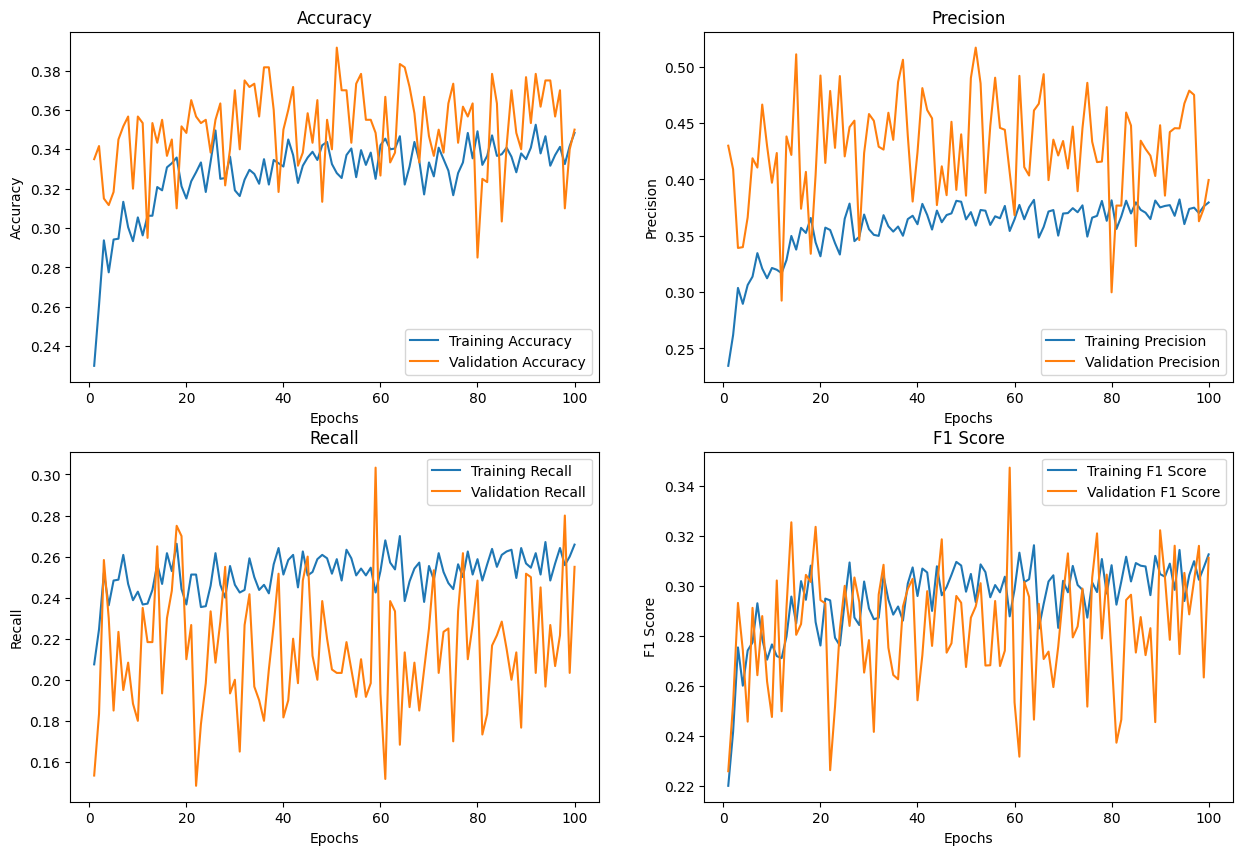

In [ ]:
import matplotlib.pyplot as plt

# Get the accuracy, precision, recall, and f1 score from the history dictionary
accuracy = history.history['accuracy']
precision = history.history['precision']
recall = history.history['recall']
f1_score = history.history['f1_score']

# Get the validation accuracy, precision, recall, and f1 score from the history dictionary
val_accuracy = history.history['val_accuracy']
val_precision = history.history['val_precision']
val_recall = history.history['val_recall']
val_f1_score = history.history['val_f1_score']

# Get the number of epochs
epochs = range(1, len(accuracy) + 1)

# Create a figure with four subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot the accuracy and validation accuracy on the first subplot
axs[0, 0].plot(epochs, accuracy, label='Training Accuracy')
axs[0, 0].plot(epochs, val_accuracy, label='Validation Accuracy')
axs[0, 0].set_title('Accuracy')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()

# Plot the precision and validation precision on the second subplot
axs[0, 1].plot(epochs, precision, label='Training Precision')
axs[0, 1].plot(epochs, val_precision, label='Validation Precision')
axs[0, 1].set_title('Precision')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Precision')
axs[0, 1].legend()

# Plot the recall and validation recall on the third subplot
axs[1, 0].plot(epochs, recall, label='Training Recall')
axs[1, 0].plot(epochs, val_recall, label='Validation Recall')
axs[1, 0].set_title('Recall')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Recall')
axs[1, 0].legend()

# Plot the f1 score and validation f1 score on the fourth subplot
axs[1, 1].plot(epochs, f1_score, label='Training F1 Score')
axs[1, 1].plot(epochs, val_f1_score, label='Validation F1 Score')
axs[1, 1].set_title('F1 Score')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('F1 Score')
axs[1, 1].legend()

# Show the plot
plt.show()


19/19 [==============================] - 9s 476ms/step


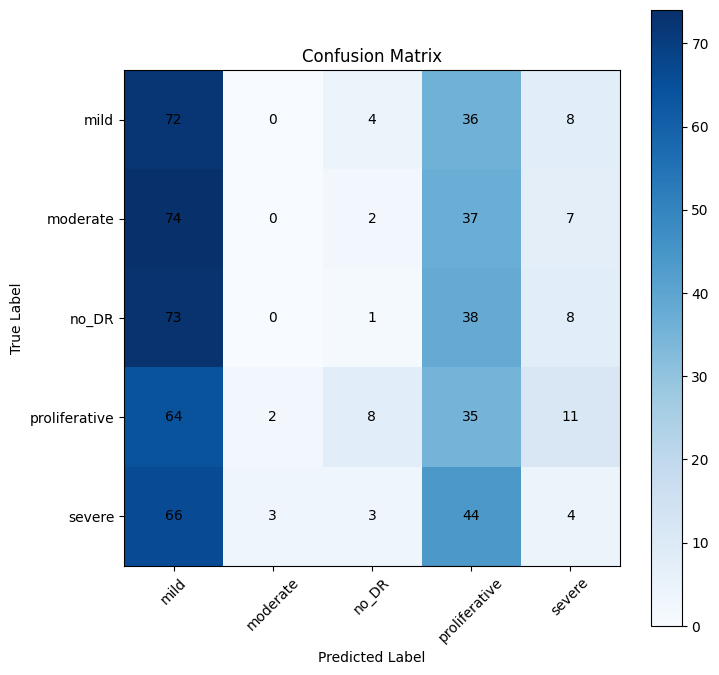

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get the predictions from the model
predictions = model.predict(val_set)

# Get the true labels from the validation set
true_labels = val_set.classes

# Convert the predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define the class labels
class_labels = ['mild', 'moderate', 'no_DR', 'proliferative', 'severe']

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Fill the matrix with numbers
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j, i, str(cm[i][j]), ha='center', va='center', color='black')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
# Get the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define the class labels
class_labels = ['mild', 'moderate', 'no_DR', 'proliferative', 'severe']

# Create a table to display the confusion matrix
table = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Add the TP, TN, FP, and FN values to the table
table['TP'] = np.diag(cm)
table['TN'] = np.sum(cm) - np.diag(cm) - np.sum(cm, axis=1) + np.diag(cm)
table['FP'] = np.sum(cm, axis=0) - np.diag(cm)
table['FN'] = np.sum(cm, axis=1) - np.diag(cm)

# Display the table
print(table)


               mild  moderate  no_DR  proliferative  severe  TP   TN   FP   FN
mild             72         0      4             36       8  72  480  277   48
moderate         74         0      2             37       7   0  480    5  120
no_DR            73         0      1             38       8   1  480   17  119
proliferative    64         2      8             35      11  35  480  155   85
severe           66         3      3             44       4   4  480   34  116
